# Animal Classification

[Dataset on Kaggle](https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals)
[Github Repository](https://github.com/LBONTEN/Animal-recognition)

### Introduction
In tnis project we will be trying to create an image classification model. Which can distinguish 90 different animal species based on an image.
To achieve this, we will make use of a Convolutional Neural Network or CNN. An archetype frequently used for this task. It will learn the visual patterns of our animal species by analyzing every pixel of the image, organized in a matrix. These pixels are represented by a number stored in a byte, meaning these pixels can have a value ranging from 0 (black) to 255 (white).

### upcoming Challenges
The dataset we will be using is a dataset obtained from Kaggle. It contains 60 unique images of 90 animal species. And right from the start this does not seem very promising. Sixty images is not a lot for a model to accurately learn any patterns. And the chances of running into overfitting are significantly high if we do not take any measures to prevent it. 
Luckily, we can make use of a few tricks. The best way to prevent overfitting is by obtaining more data for the model to work with. And for this we can make use of Data Augmentation. With Data Augmentation we can generate more data by performing transformations on the existing data. We can rotate an image, flip an image, zoom into an image, and so forth. By doing this, we push our model to learn the visual patterns that are actually relevant to recognize the species.
Another popular approach for tackling overfitting is a Dropout layer. With this we tell the model to drop a random selection of its results after every iteration. This way we might prevent it from learning the wrong visual patterns. Which should in turn improve the accuracy of the models' predictions. Statistically.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense 

from sklearn.model_selection import train_test_split

## Getting the Data

We will start by reading the data from our disk and loading it into a numpy array. We will use a Keras utility function to handle this pretty easily. Since not all data is equal in resolution. We will need to define a preferable image height an width. To keep the data consistent for our model.
We also provide a seed to the keras utility function. This seed will be used to load images randomly from our disk.

In [18]:
DATA_DIR= './input/animal-image-dataset-90-different-animals/animals/animals'

seed = 111
batch_s = 32
img_h = 256
img_w = 256

data = image_dataset_from_directory(
    DATA_DIR,
    seed=seed,
    image_size=(img_h, img_w),
    batch_size=batch_s
)
classes = data.class_names

images = []
labels = []
for img, label in data.unbatch():
	images.append(img)
	labels.append(label)

np_data = (np.array(images), np.array(labels))

Found 5400 files belonging to 90 classes.


2022-08-28 22:46:31.073289: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 44709282 exceeds 10% of free system memory.
2022-08-28 22:46:33.698680: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 43603791 exceeds 10% of free system memory.


## Data Exploration

Since the data we will use for this project consists solely of images. I find the best way to explore it is by simply looking at it.
The most important goal in this step is to find out there are no obvious discrepancies in our labeling. And that the image data itself is loaded correctly from disk.
As to not clutter the entire screen with animal pictures (although that doesn't actually sound so bad) we will limit our exploration to the top 9 images.

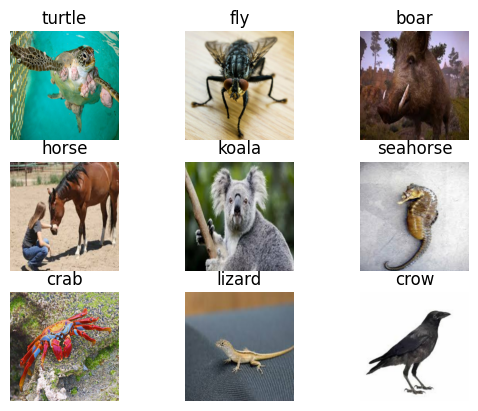

In [2]:

for i in range(9):
	ax = plt.subplot(3, 3, i + 1)
	plt.imshow(np_data[0][i].astype("uint8"))
	plt.title(classes[np_data[1][i]])
	plt.axis("off")

## Splitting the data

Now we need to split our data into a training and validation split. Seeing as we do not have a lot of data to begin with. I will keep a large portion of it for training. The more data we keep for training, the more data we can also augment later.
I will also not keep a separate test split, again due to our limited data.

In [3]:
val_split = 0.2

x_trn, x_tst, y_trn, y_tst = train_test_split(np_data[0], np_data[1], test_size=val_split)

## Normalization & Data Augmentation 

For the model to work with our data more easily, we need to scale the values [0-255] to a range of [0-1]. This process is called normalization and will happen in this step.
After that we will also perform our data augmentation, this is where we rotate, shift, flip, zoom, twist and bop our images. As to keep our model on edge.

In [4]:

trn_datagen = ImageDataGenerator(
	rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
	vertical_flip=True,
    shear_range=0.2, 
    zoom_range=[0.8, 1.2]
)

val_datagen = ImageDataGenerator(
	rescale=1./255
)	
	

## Model Definition

Here we define the architecture of our model. We start of with a pretrained model called DenseNet121. This model already contains the Convolution layers and MaxPooling layers we need for this task. We still, however, need to train this model for our own particular case. That's why I still need to feed it our data and define the output layers. So we can receive results that we can use. For our final layer we want to make use of the Softmax activation function. So we can get the prediction of our model as an array. containing one probability for each of our 90 species.


Aside from that we select Adam as our optimalization function. And since we are working with categorical data, we will make use of the Sparse Categorical Cross Entropy loss function.

In [5]:

pretrained_model = DenseNet121(
	input_shape=(img_h, img_w, 3), 
	include_top=False, 
	weights='imagenet', 
	pooling='avg'
)

pretrained_model.trainable = False
inputs = pretrained_model.input


dense = Dense(128, activation='relu')(pretrained_model.output)
outputs = Dense(90, activation='softmax')(dense)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

## Model Training

In [6]:

epochs=10
history = model.fit(
  trn_datagen.flow(x_trn, y_trn, batch_size=batch_s),
  validation_data=val_datagen.flow(x_tst, y_tst, batch_size=batch_s),
  epochs=epochs
)

Epoch 1/10


/home/lenny/Projects/Machine learning/Animal-recognition/venv/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


135/135 [==============================] - 392s 3s/step - loss: 3.7237 - accuracy: 0.1845 - val_loss: 2.2277 - val_accuracy: 0.5056
Epoch 2/10
135/135 [==============================] - 367s 3s/step - loss: 1.9943 - accuracy: 0.5366 - val_loss: 1.1670 - val_accuracy: 0.7269
Epoch 3/10
135/135 [==============================] - 341s 3s/step - loss: 1.3423 - accuracy: 0.6579 - val_loss: 0.9032 - val_accuracy: 0.7537
Epoch 4/10
135/135 [==============================] - 345s 3s/step - loss: 1.0823 - accuracy: 0.7280 - val_loss: 0.7273 - val_accuracy: 0.7935
Epoch 5/10
135/135 [==============================] - 345s 3s/step - loss: 0.9353 - accuracy: 0.7509 - val_loss: 0.6623 - val_accuracy: 0.8093
Epoch 6/10
135/135 [==============================] - 417s 3s/step - loss: 0.8399 - accuracy: 0.7671 - val_loss: 0.6017 - val_accuracy: 0.8269
Epoch 7/10
135/135 [==============================] - 464s 3s/step - loss: 0.7594 - accuracy: 0.7928 - val_loss: 0.5537 - val_accuracy: 0.8287
Epoch 8/10

## Accuracy & Loss Analysis

Thanks to the Keras utility library, we can extract the metrics of our training from the history variable. Making it easy to access and plotting these metrics.

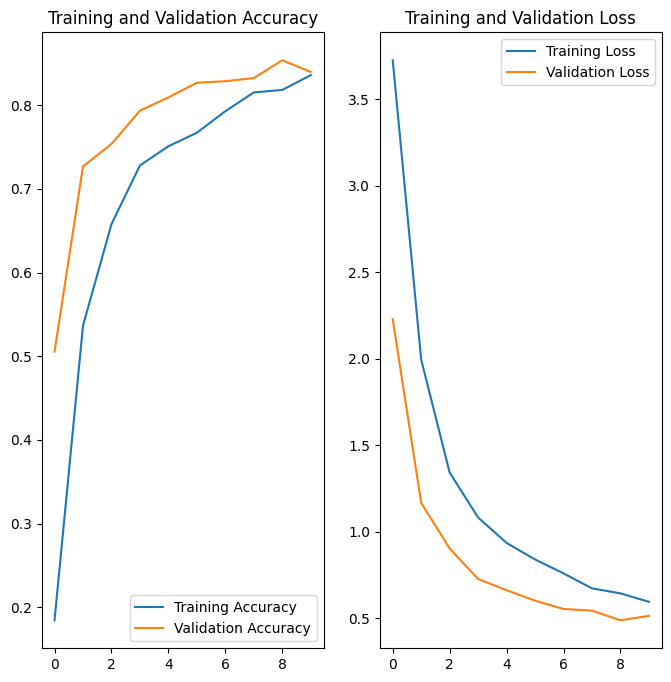

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [8]:

model.save('models/model.h5')

## Performing Predictions

Let us finish this project by using our trained model to make some predictions. The images used for these predictions were taken at random from the internet. And were of course never used during the training of our model. Sadly we did not have enough data to properly keep a test set of images. So this section is more about detecting any obvious mishaps. Than it is for actually testing the model. Nevertheless we can still showcase these limited test results.

In [79]:
def prepare_image(image):
	image_arr = img_to_array(image)
	image_arr = image_arr/255.0
	image_arr = image_arr.reshape(1, 256, 256, 3)
	return image_arr
	

def plot_top_five(predictions):
	data = {}
	for i in range(5):
		idx = np.argmax(predictions)
		data[classes[idx]] = predictions[idx]
		predictions[idx] = 0

	# data = {'apple': 10, 'orange': 15, 'lemon': 5, 'lime': 20}
	names = list(reversed(data.keys()))
	values = list(reversed(data.values()))

	fig, axs = plt.subplots(1, figsize=(9, 3), sharey=True)
	axs.barh(names, values)
	fig.suptitle('Top 5 Predictions')
	
	
model = keras.models.load_model('models/model.h5')

1/1 [==============================] - 2s 2s/step


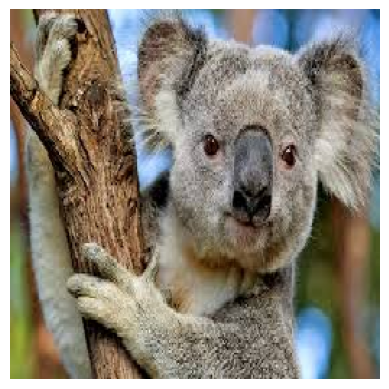

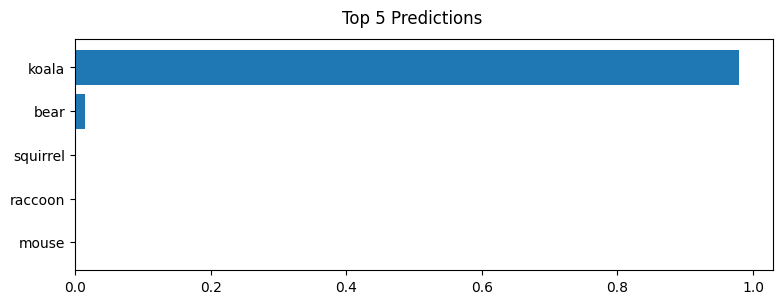

In [80]:
image_path = "input/images.jpeg"
image = load_img(image_path, target_size=(256,256))
plt.imshow(image)
plt.axis("off")

# PREDICTION
image = prepare_image(image)
predictions= model.predict(image)

plot_top_five(predictions[0])

1/1 [==============================] - 0s 111ms/step


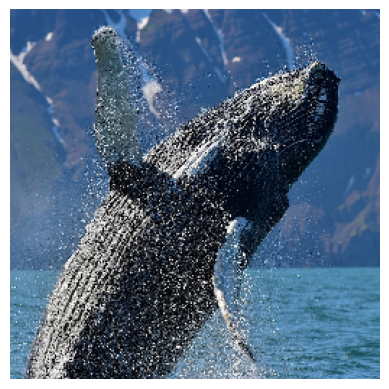

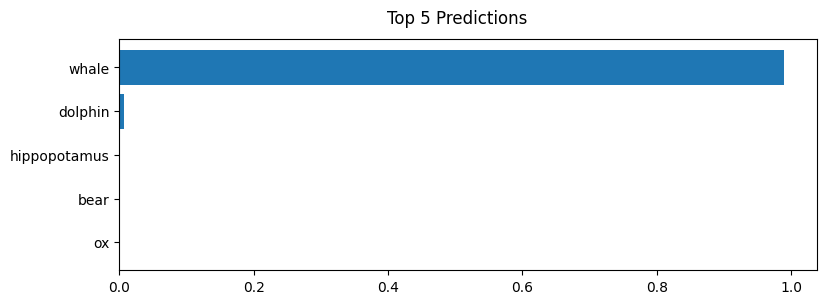

In [81]:

image_path="input/the-best-guide-to-whale-watching-in-iceland-3.jpeg"
image=load_img(image_path, target_size=(256,256))
plt.imshow(image)
plt.axis("off")

# PREDICTION
image = prepare_image(image)
predictions= model.predict(image)

plot_top_five(predictions[0])

1/1 [==============================] - 0s 98ms/step


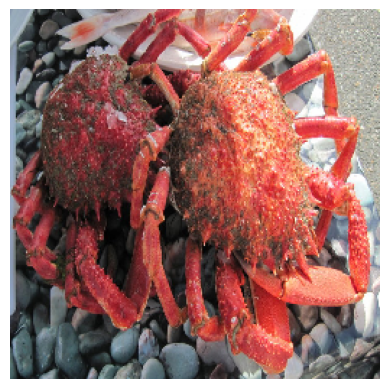

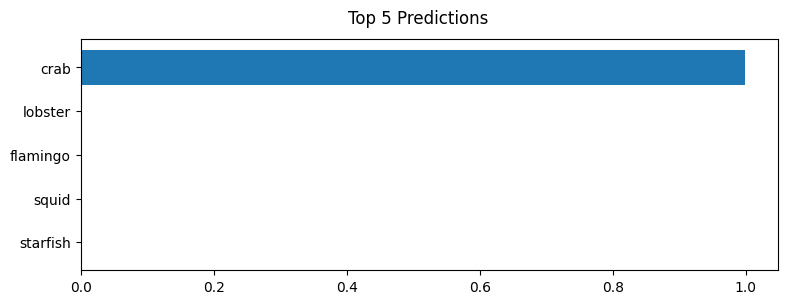

In [82]:
image_path="input/rsz-1cornish-cooked-spider-crab-photo-by-abby-crosby-resized-for-web.jpg"
image=load_img(image_path, target_size=(256,256))
plt.imshow(image)
plt.axis("off")

# PREDICTION
image = prepare_image(image)
predictions= model.predict(image)

plot_top_five(predictions[0])

1/1 [==============================] - 0s 98ms/step


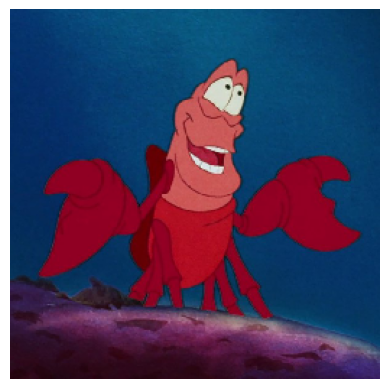

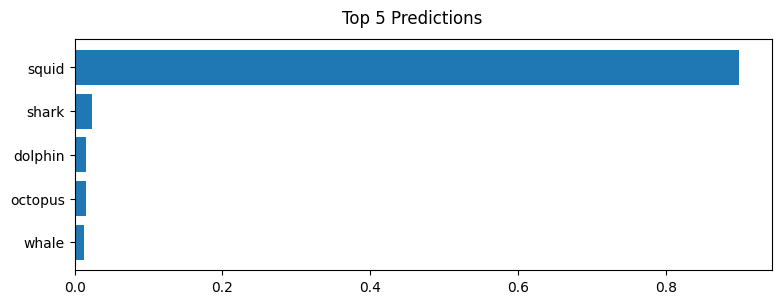

In [83]:
image_path="input/main-qimg-6f596808026af8717dc298b47e8a372b-lq.jpeg"
image=load_img(image_path, target_size=(256,256))
plt.imshow(image)
plt.axis("off")

# PREDICTION
image = prepare_image(image)
predictions= model.predict(image)

plot_top_five(predictions[0])

## Conclusion

### Things I learnt
More than anything, this project has taught me the importance of having proper data as well as having enough of it. The Data Augmentation I used during this project has certainly saved this project. Though our results could have been even better by simply getting more quality data.

There are definitely other approaches I could have taken however. While researching the method to handle this task. I encountered a particularly interesting submission on Kaggle. The person behind this submission managed to find an even worse dataset than I have. This dataset contained over a 130 classes, with images per class ranging between 20 and 60.
Still he managed to achieve a +80% accuracy by using multiple models. CNN's generally need to have a lot of data per class. The more classes a dataset has, the more data it needs. But you might be able to group up some of your classes in superclasses. Then you train a model to categorize the data using these superclasses. This way you have a lot more data per class. And the chance of success for our model will be much higher. Then for each of these superclasses you train a model to recognize the classes you wanted from the beginning. This way you can already eliminate a lot of options. Once more increasing success rates.
Of course this approach also has it's downsides. First of all you need to do a lot of training. Especially if you don't succeed in keeping the number of superclasses low. And a lot of moving parts simply mean a lot can go wrong. If model 1 and 2 both have an accuracy of 80%, the overall accuracy will still only be 64%. 
Still, I think this approach would probably still work better than simply having a single model which is supposed to do it all.

This approach has rather stuck in the back of my head. Though I didn't get to use it during this project. 